In [11]:
from skimage import io
import matplotlib.pyplot as plt
from filter import *
from segment_graph import *
import time
import PIL
from collections import Counter

In [12]:
# read images from samples folder
import os

files = os.listdir("samples/")
sample_colors = np.zeros(shape=(len(files), 3))
name_to_color = {}
pixel_id_to_label = {}
all_sample_pixels = []
for file in files:
    input_image = io.imread("samples/" + file)
    # ignore pixels with alpha channel equal to 0 and compute mean of RGB values
    ind_pixels = input_image[input_image[:, :, 3] != 0]
    
    
    mean_color = np.mean(input_image[input_image[:, :, 3] != 0], axis=0)
    sample_colors[files.index(file)] = mean_color[:3].astype(int)
    name_to_color[file.split(".")[0]] = mean_color[:3].astype(int)
    # sample 1000 only
    ind_pixels = ind_pixels[np.random.choice(ind_pixels.shape[0], 100, replace=False)]
    for i in range(len(ind_pixels)):
        all_sample_pixels.append(ind_pixels[i][:3])
        pixel_id_to_label[len(pixel_id_to_label)] = file.split(".")[0]

all_sample_pixels = np.array(all_sample_pixels)
print(all_sample_pixels.shape)
# all_sample_pixels = np.concatenate(all_sample_pixels, axis=0)

def most_similar_to(ind_pixels, given_color, top_k):
    # compare to individual pixels, get the top_k most similar colors
    similarities = np.dot(ind_pixels, given_color) / (np.linalg.norm(ind_pixels, axis=1) * np.linalg.norm(given_color))
    # similarities = np.exp(similarities)
    # similarities /= np.sum(similarities)
    top_k_indices = np.argsort(similarities)[-top_k:]
    # fetch the top_k labels using pixel_id_to_label
    top_k_labels = []
    for tkl in top_k_indices:
        top_k_labels.append(pixel_id_to_label[tkl])
    
    # apply voting
    
    c = Counter(top_k_labels)
    color_name  = c.most_common(1)[0][0]
    return name_to_color[color_name]

def similar_color(samples, color, threshold):
    if np.linalg.norm(color) == 0:
        return 0
    # apply cosine similarity and softmax
    # print(color, np.linalg.norm(color))
    similarities = np.dot(samples, color) / (np.linalg.norm(samples, axis=1) * np.linalg.norm(color))
    similarities = np.exp(similarities)
    similarities /= np.sum(similarities)
    # return the most similar color
    return np.argmax(similarities)

# similar_color(sample_colors, np.array([0, 0, 0]), 0.5)

most_similar_to(all_sample_pixels, np.array([113, 27, 98]), 10)


(500, 3)


array([179, 166, 144])

Loading is done.
processing...
Height:  430
Width:   548
Execution time: 0 minute(s) and 25 seconds


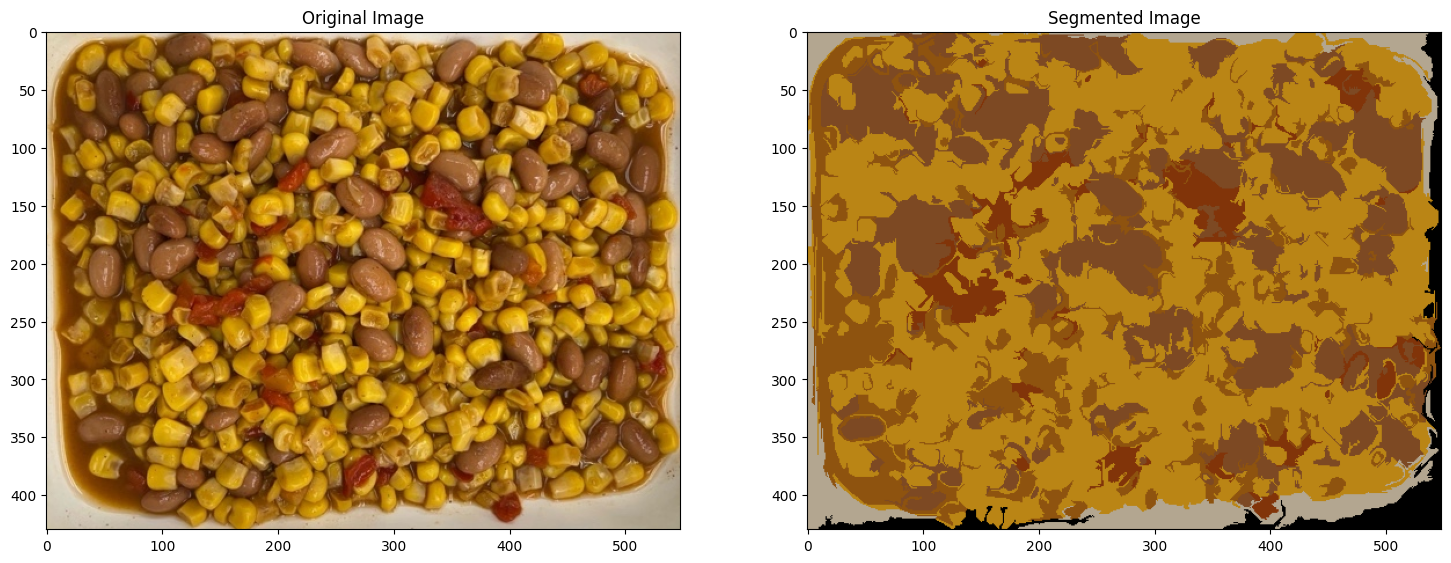

In [13]:
def segment(in_image, sigma, k, min_size, num_classes=4):
    start_time = time.time()
    height, width, band = in_image.shape
    print("Height:  " + str(height))
    print("Width:   " + str(width))
    smooth_red_band = smooth(in_image[:, :, 0], sigma)
    smooth_green_band = smooth(in_image[:, :, 1], sigma)
    smooth_blue_band = smooth(in_image[:, :, 2], sigma)

    # build graph
    edges_size = width * height * 4
    edges = np.zeros(shape=(edges_size, 3), dtype=object)
    num = 0
    for y in range(height):
        for x in range(width):
            if x < width - 1:
                edges[num, 0] = int(y * width + x)
                edges[num, 1] = int(y * width + (x + 1))
                edges[num, 2] = diff(smooth_red_band, smooth_green_band, smooth_blue_band, x, y, x + 1, y)
                num += 1
            if y < height - 1:
                edges[num, 0] = int(y * width + x)
                edges[num, 1] = int((y + 1) * width + x)
                edges[num, 2] = diff(smooth_red_band, smooth_green_band, smooth_blue_band, x, y, x, y + 1)
                num += 1

            if (x < width - 1) and (y < height - 1):
                edges[num, 0] = int(y * width + x)
                edges[num, 1] = int((y + 1) * width + (x + 1))
                edges[num, 2] = diff(smooth_red_band, smooth_green_band, smooth_blue_band, x, y, x + 1, y + 1)
                num += 1

            if (x < width - 1) and (y > 0):
                edges[num, 0] = int(y * width + x)
                edges[num, 1] = int((y - 1) * width + (x + 1))
                edges[num, 2] = diff(smooth_red_band, smooth_green_band, smooth_blue_band, x, y, x + 1, y - 1)
                num += 1
    # Segment
    u = segment_graph(width * height, num, edges, k)

    # post process small components
    for i in range(num):
        a = u.find(edges[i, 0])
        b = u.find(edges[i, 1])
        if (a != b) and ((u.size(a) < min_size) or (u.size(b) < min_size)):
            u.join(a, b)

    num_cc = u.num_sets()
    output = np.zeros(shape=(height, width, 3))

    # pick random colors for each component
    colors = np.zeros(shape=(height , width, 3))

    kernel = 9
    for y in range(height - kernel):
        for x in range(width - kernel):
            # colors[y, x, :] = average_neighborhood(in_image, 5, x, y)
            patch = in_image[y:y+kernel, x:x+kernel]
            current_colors = np.median(patch, axis=(0, 1))
            # current_colors = in_image[y, x]
            
            # color_pick = similar_color(sample_colors, current_colors, 0.5)
            # colors[y, x, :] = sample_colors[color_pick]
            colors[y, x, :] = most_similar_to(all_sample_pixels, current_colors, 10)

            
    colors = colors.reshape((height * width, 3))
    
    for y in range(height):
        for x in range(width):
            comp = u.find(y * width + x)
            output[y, x, :] = colors[comp, :]

    elapsed_time = time.time() - start_time
    print(
        "Execution time: " + str(int(elapsed_time / 60)) + " minute(s) and " + str(
            int(elapsed_time % 60)) + " seconds")

    # displaying the result
    fig = plt.figure(figsize=(18, 9))
    a = fig.add_subplot(1, 2, 1)
    plt.imshow(in_image)
    a.set_title('Original Image')
    a = fig.add_subplot(1, 2, 2)
    output = output.astype(int)
    plt.imshow(output)
    a.set_title('Segmented Image')
    plt.show()
    return output

sigma = 1.0
k = 100
min = 20
input_path = "../cimage3.png"
num_classes = 4

# Loading the image
input_image = io.imread(input_path)
# convert to RGB
if input_image.shape[2] == 4:
    input_image = input_image[:, :, :3]
print("Loading is done.")
print("processing...")
output = segment(input_image, sigma, k, min, num_classes)


In [14]:
# based on name_to_color, compute percentage of each color
# remove background color
output_rows = output.reshape((output.shape[0] * output.shape[1], 3))
background = name_to_color["background"]
clean_output = (output_rows != background).sum(axis=1) > 0
clean_output = output_rows[clean_output]
# non-zero colors
clean_output = clean_output[clean_output.sum(axis=1) > 0]
# compute percentage of each color
percentage = {}
for i, color in name_to_color.items():
    if i == "background":
        continue
    color_count = ((clean_output == color).sum(axis=1) > 0)
    percentage[i] = color_count.sum() / clean_output.shape[0]
    # print with 2 decimal places
    print(i + " : " + "{:.2f}".format(percentage[i] * 100) + "%")


liquid : 15.41%
corn : 54.34%
beans : 24.71%
tomato : 5.54%
